# Import Libraries

In [205]:
import os
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Enter Folder Name

In [206]:
# Enter Name of your directory here
trial_dir = 'C:/Users/aadit/Documents/GitHub/Retinal-Image-Registration-SOP/1_Input_Images'

trial_dir = 'C:/Users/aadit/Documents/GitHub/Retinal-Image-Registration-SOP/trial'
# trial_dir = 'C:/Users/aadit/Documents/GitHub/Retinal-Image-Registration-SOP/2_Manually_Cropped_Images'
# trial_dir = 'C:/Users/aadit/Google Drive/Art/Clip Studio Paint/PNGs'

type = 'jpg'

d, _, fs = next(os.walk(trial_dir))

In [207]:
def load_img(image_path):
    image = tf.io.read_file(image_path)
    if type == 'jpg':
        image = tf.image.decode_jpeg(image, channels = 3)
        
    elif type == 'png':
        image = tf.image.decode_png(image, channels = 3)
    else:
        image = tf.image.decode_image(image, channels = 3)
    
    return image

print(fs[0])

bhanu_123703 - Copy.jpg


In [208]:
# See Your Images
# n = len(fs)
# trials = [load_img( os.path.join(trial_dir, fs[i])) for i in range(n)]
# fig, axs = plt.subplots(n, 1, figsize = (6, 3*n), constrained_layout = True)
# for ax, image in zip(axs, trials):
#     ax.imshow(image)

# Image Preprocessing

In [209]:
def resize_trial_images(images):
    target_height, target_width = 128, 128
    images = tf.cast(images, tf.float32)
    images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return images

def scale_trial_values(images):
    images = tf.math.divide(images, 255)
    return images


In [210]:
if type == 'jpg':
    ds = tf.data.Dataset.list_files(trial_dir+'/*.jpg', seed = 4)
elif type == 'png':
    ds = tf.data.Dataset.list_files(trial_dir+'/*.png', seed = 4)
else:
    ds = tf.data.Dataset.list_files(trial_dir+'/*.tif', seed = 4)
trial_set_size = len(fs)

trial_dataset = ds.take(trial_set_size)
trial_dataset = trial_dataset.map(load_img)
trial_dataset = trial_dataset.map(scale_trial_values)
trial_dataset = trial_dataset.shuffle(20)
trial_dataset = trial_dataset.map(resize_trial_images)

trial_dataset = trial_dataset.batch(1).prefetch(5)


# U-Net Model

In [211]:
def conv_block(inputs, n_filters, max_Pooling = True):
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)
  
  if max_Pooling:
    down_output = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
  else:
    down_output = conv
  skip_output = conv

  return down_output, skip_output




In [212]:
def up_block(up_input, skip_input, n_filters):
  up = keras.layers.Conv2DTranspose(n_filters, kernel_size=3, strides = (2,2), padding = 'same')(up_input)
  sum = keras.layers.concatenate([up, skip_input], axis= 3)

  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(sum)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)

  return conv

In [213]:
def unet_model(input_size , n_filters, n_classes):
  inputs = keras.layers.Input(input_size)

  down_block_1 = conv_block(inputs, n_filters, max_Pooling=True)
  down_block_2 = conv_block(down_block_1[0], n_filters*2, max_Pooling=True)
  down_block_3 = conv_block(down_block_2[0], n_filters*4, max_Pooling=True)
  down_block_4 = conv_block(down_block_3[0], n_filters*8, max_Pooling=True)
  down_block_5 = conv_block(down_block_4[0], n_filters*16, max_Pooling=False)

  up_block_6 = up_block(down_block_5[0], down_block_4[1], n_filters*8)
  up_block_7 = up_block(up_block_6, down_block_3[1], n_filters*4)
  up_block_8 = up_block(up_block_7, down_block_2[1], n_filters*2)
  up_block_9 = up_block(up_block_8, down_block_1[1], n_filters)

  conv_9 = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(up_block_9)

  conv_10 = keras.layers.Conv2D(n_classes, kernel_size = 1, activation = 'sigmoid')(conv_9)

  model = keras.Model(inputs = inputs, outputs= conv_10)

  return model

In [214]:
model = unet_model(input_size=(128, 128, 3), n_filters= 32, n_classes= 3)

model.compile(optimizer = 'adam', 
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [215]:
checkpoint_path = "C:/Users/aadit/Google Drive (f20190077@pilani.bits-pilani.ac.in)/Personal Projects/U Nets/Trained Models/training_2 (18 epochs, 32 batch size)/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Load Weights


In [216]:
model.load_weights(checkpoint_path)

# Seeing Results

(2, 2)


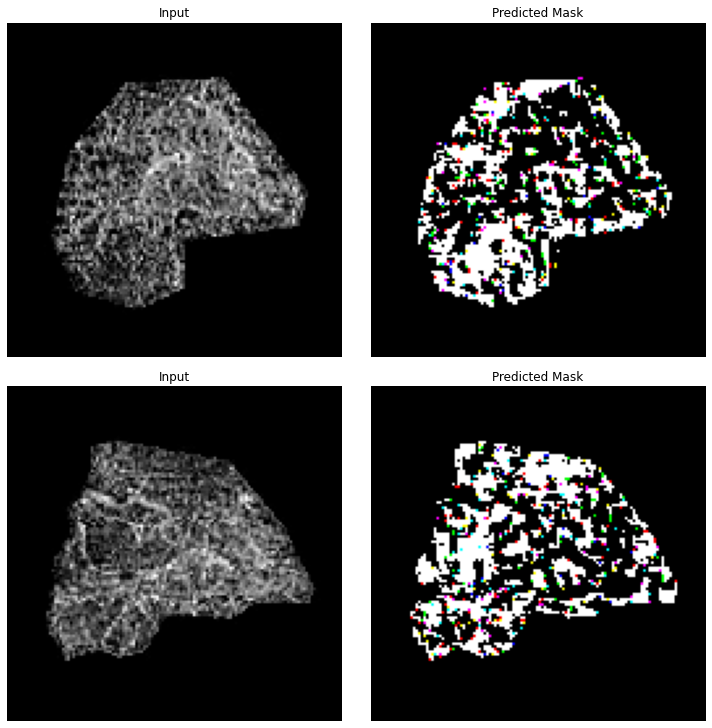

In [218]:
n = len(fs)
tries = trial_dataset.take(n)
i, m, p, pred, p_2D = None, None, None, None, None

threshold = 0.5
 

fig, axs = plt.subplots(n, 2, figsize = (10, 5*n), constrained_layout= True )
print(axs.shape)
for ax, image in zip(axs, tries):
    i = image
    p_raw = model.predict(image) # Shape: 1, 128, 128, 3
    p = p_raw[0] # Shape: 128, 128, 3
    pred = tf.where(p>threshold, 0, 255) # Shape: 128, 128, 3
    
    ax[0].imshow(i[0])
    ax[0].axis('off')
    ax[0].set_title("Input")
    
    ax[1].imshow(pred)
    ax[1].axis('off')
    ax[1].set_title("Predicted Mask")
    
